In [1]:
# # install  Augraphy, the main image augmentation library

# !pip install augraphy
# # or
# !pip install git+https://github.com/sparkfish/augraphy

In [2]:
# # download and unzip document image data

# !pip install gdown
# !pip install --upgrade gdown

# !gdown --id 1uJPavzL7K3FFr9MEfZbdX3SNa1bGEdPu
# !unzip shabby_small.zip

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1uJPavzL7K3FFr9MEfZbdX3SNa1bGEdPu
From (redirected): https://drive.google.com/uc?id=1uJPavzL7K3FFr9MEfZbdX3SNa1bGEdPu&confirm=t&uuid=37c63c68-9d79-4ebb-872b-3969ea2be787
To: /data/ephemeral/home/upstage-cv-classification-cv6/JYL/examples/shabby_small.zip
100%|██████████████████████████████████████| 61.1M/61.1M [00:00<00:00, 63.8MB/s]
Archive:  shabby_small.zip
   creating: shabby_small/
   creating: shabby_small/test/
   creating: shabby_small/test/test_clean/
   creating: shabby_small/test/test_clean/clean/
  inflating: shabby_small/test/test_clean/clean/0004-State-2021_How-to-Password-Protect-PDF-Documents.pdf-2.png  
  inflating: shabby_small/test/test_clean/clean/0005-IRS-irs-pdf_i1120f.pdf-09.png  
  i

In [3]:
# import libraries

import sys
import glob
import cv2
import numpy as np

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets, models
from torch.nn.modules.loss import BCEWithLogitsLoss
from torch.optim import lr_scheduler

from torch.autograd import Variable

from matplotlib import pyplot as plt
from time import time

In [4]:
# create an Augraphy augmentation pipeline

from augraphy import *

ink_phase = [Dithering(p=0.5),
             InkBleed(p=0.5),
             OneOf([LowInkRandomLines(p=1), LowInkPeriodicLines(p=1)]),
            ]

paper_phase = [ColorPaper(p=0.5)]

post_phase = [Markup(p=0.25),
              DirtyRollers(p=0.25),
              Scribbles(p=0.25),
              BindingsAndFasteners(p=0.25),
              BadPhotoCopy(p=0.25),
              DirtyDrum(p=0.25),
              ]

augmentation_pipeline = AugraphyPipeline(ink_phase=ink_phase, paper_phase=paper_phase, post_phase=post_phase)


In [5]:
# create augmentation object

class To_Tensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, image):
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        #if len(image.shape)>2:
        #    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        if len(image.shape)<3:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

        image = image.reshape(3, image.shape[0], image.shape[1])

        return torch.from_numpy(image.astype("float64")/255)

class To_BGR(object):
    """Convert from PIL RGB Image to numpy array BGR image."""
    def __call__(self, image):
        # convert from PIL RGB to BGR
        image_numpy = np.array(image)
        if len(image_numpy.shape)<3:
            return cv2.cvtColor(image_numpy, cv2.COLOR_GRAY2BGR)
        else:
            return cv2.cvtColor(image_numpy, cv2.COLOR_RGB2BGR)

# augmentations for clean and dirty images
dirty_transforms = transforms.Compose([To_BGR(),
                                       augmentation_pipeline,
                                       To_Tensor()])
clean_transforms = transforms.Compose([To_BGR(), To_Tensor()])

In [6]:
# training parameters

# actual batch size will be x2 of this, due to clean+dirty images
batch_size = 16
epochs = 5
shuffle = 1
image_size = 400

In [7]:
# Create datasets

train_dirty_path = "shabby_small/train/train_dirty/"
train_clean_path = "shabby_small/train/train_clean/"

validate_dirty_path = "shabby_small/validate/validate_dirty/"
validate_clean_path = "shabby_small/validate/validate_clean/"

test_dirty_path = "shabby_small/test/test_dirty/"
test_clean_path = "shabby_small/test/test_clean/"

# create datasets
train_dirty_data = datasets.ImageFolder(train_dirty_path,transform=dirty_transforms)
train_clean_data = datasets.ImageFolder(train_clean_path,transform=clean_transforms)
validate_dirty_data = datasets.ImageFolder(validate_dirty_path,transform=dirty_transforms)
validate_clean_data = datasets.ImageFolder(validate_clean_path,transform=clean_transforms)
test_dirty_data = datasets.ImageFolder(test_dirty_path,transform=dirty_transforms)
test_clean_data = datasets.ImageFolder(test_clean_path,transform=clean_transforms)

# create dataloader
train_dirty_loader = torch.utils.data.DataLoader(train_dirty_data, shuffle = shuffle, batch_size=batch_size)
train_clean_loader = torch.utils.data.DataLoader(train_clean_data, shuffle = shuffle, batch_size=batch_size)
validate_dirty_loader = torch.utils.data.DataLoader(validate_dirty_data, shuffle = shuffle, batch_size=batch_size)
validate_clean_loader = torch.utils.data.DataLoader(validate_clean_data, shuffle = shuffle, batch_size=batch_size)
test_dirty_loader = torch.utils.data.DataLoader(test_dirty_data, shuffle = shuffle, batch_size=batch_size)
test_clean_loader = torch.utils.data.DataLoader(test_clean_data, shuffle = shuffle, batch_size=batch_size)

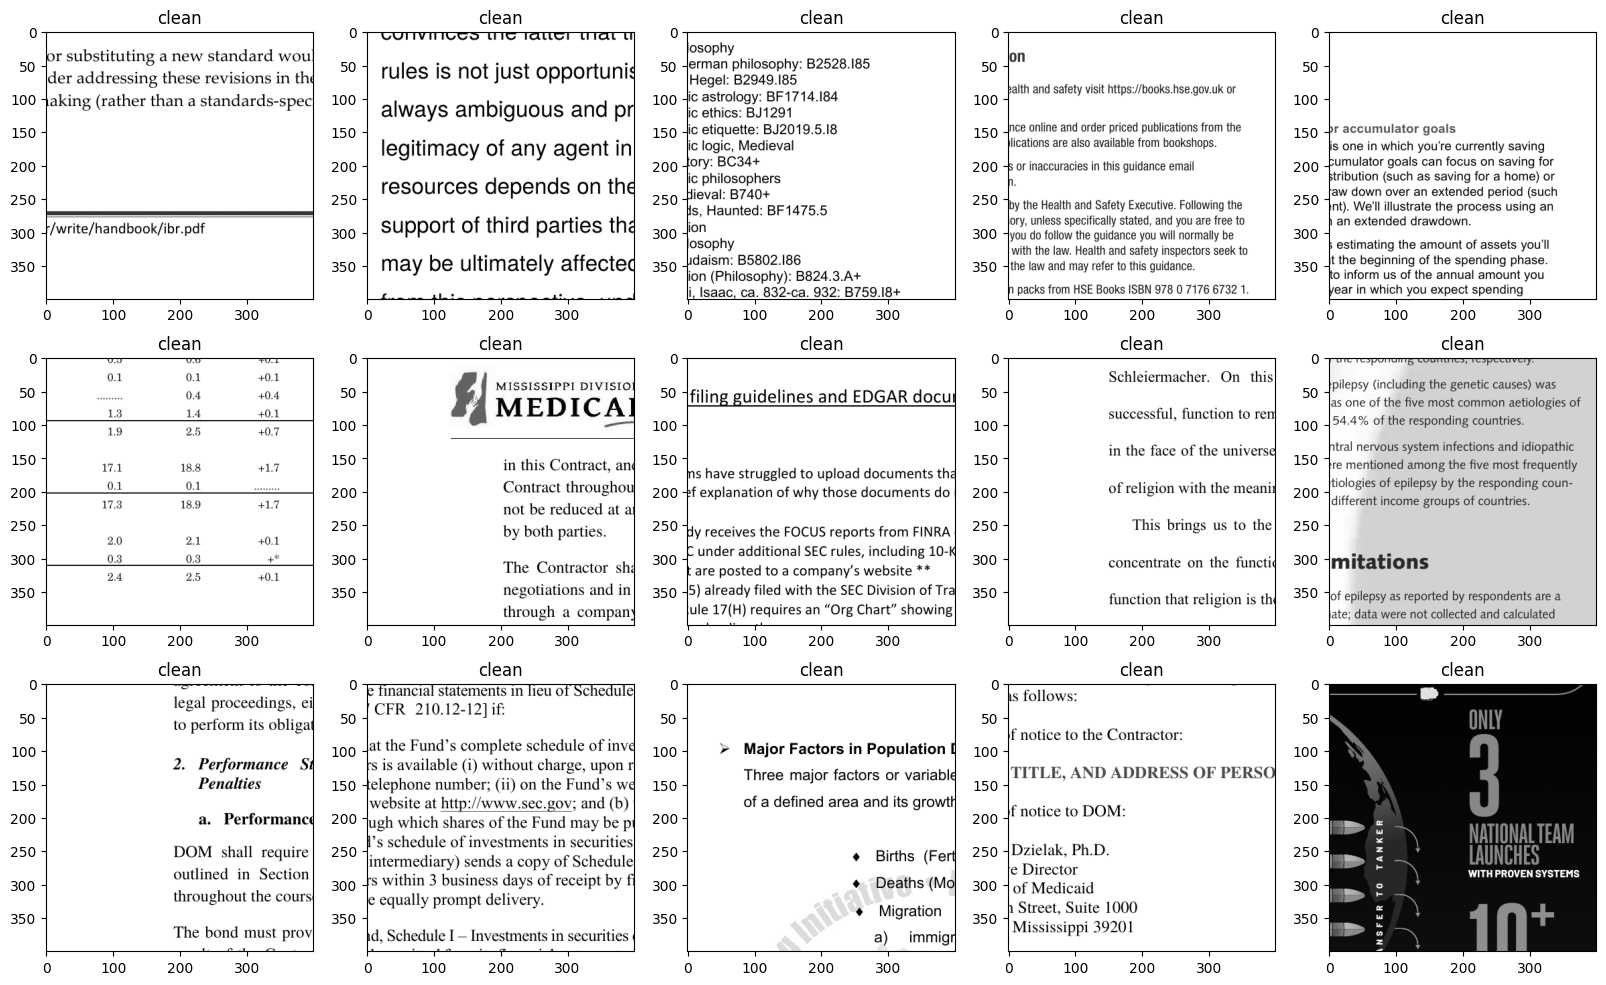

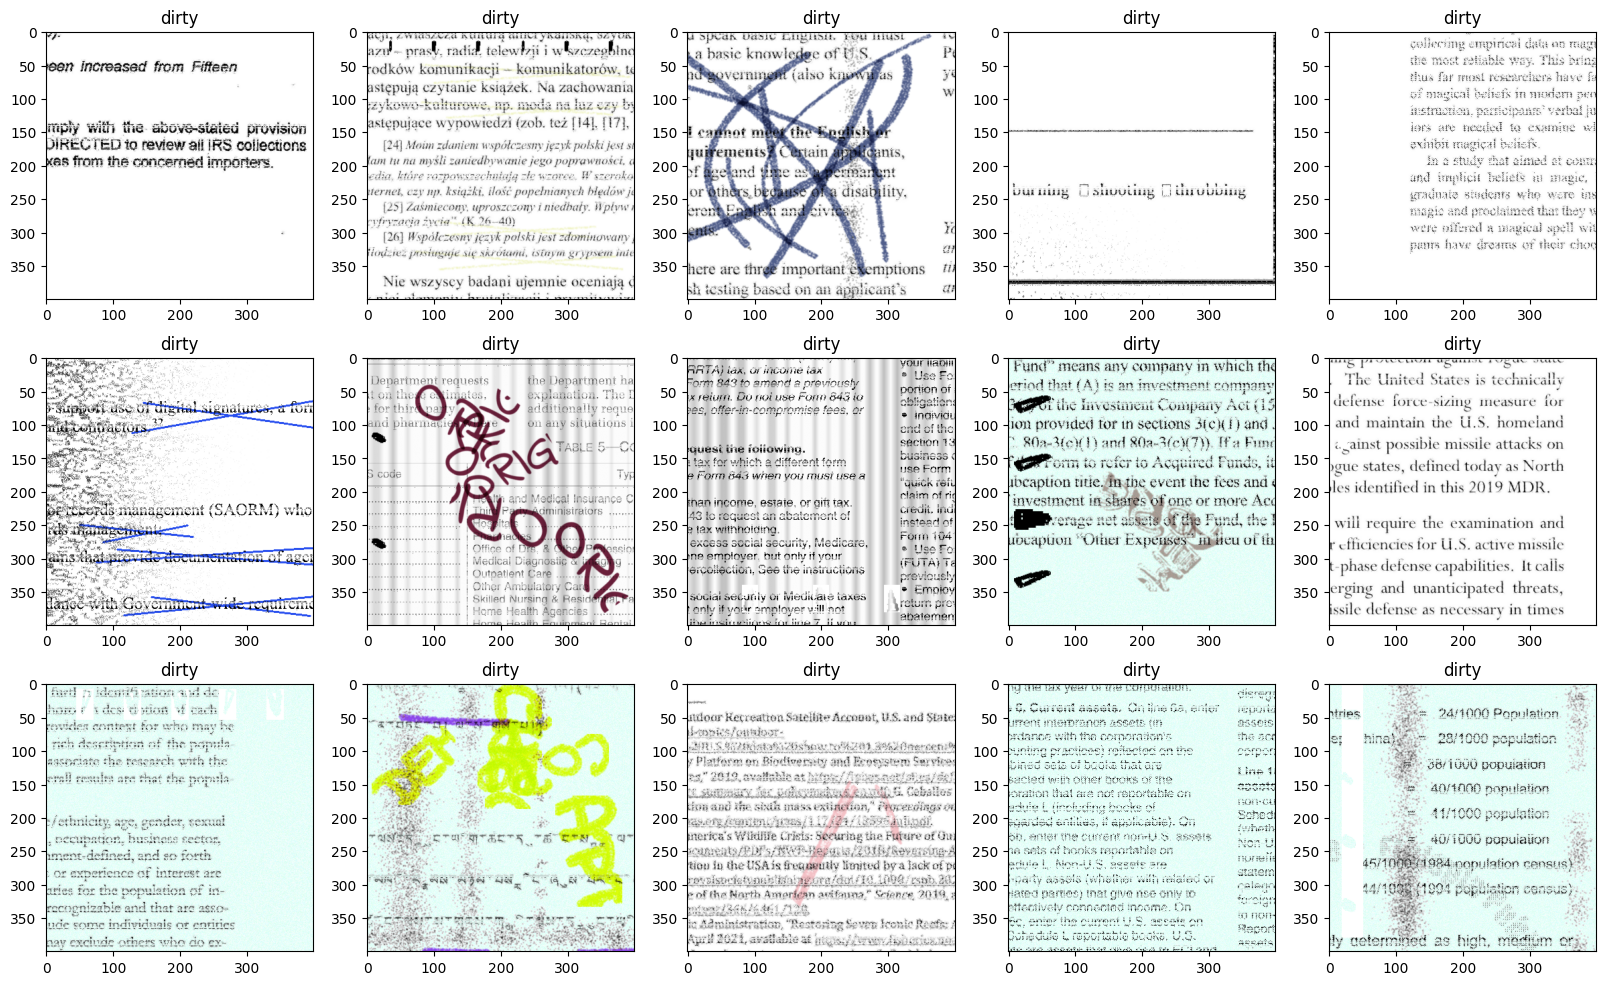

In [8]:
# Display some of the clean and dirty images

plt.rcParams["figure.figsize"] = (20,12)
# clean
for data in train_clean_loader:
    plt.figure()
    for i in range(15):
        plt.subplot(3,5,i+1)
        plt.imshow(data[0][i].reshape(image_size, image_size, 3))
        plt.title("clean")
    break

# dirty
for data in train_dirty_loader:
    plt.figure()
    for i in range(15):
        plt.subplot(3,5,i+1)
        plt.imshow(data[0][i].reshape(image_size, image_size, 3))
        plt.title("dirty")
    break

In [9]:
# Define training and model parameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define model
model =models.resnet50(pretrained=True)

# freeze all params
for params in model.parameters():
  params.requires_grad_ = False
# add final layer based on current final layer inputs to single classification output
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

# define optimizer and loss function
criterion = BCEWithLogitsLoss()  # with sigmoid
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

In [10]:
# Define training and model parameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define model
model =models.resnet50(pretrained=True)
#freeze all params
for params in model.parameters():
  params.requires_grad_ = False
# add final layer based on current final layer inputs to single classification output
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

# define optimizer and loss function
criterion = BCEWithLogitsLoss()  # with sigmoid
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)



In [11]:
# training iterations

train_losses = []
validate_losses = []

patient_count = 0
patient_threshold = 10

best_validate_loss = 100

for epoch in range(epochs):
    train_loss = 0
    start_time = time()

    # reset to training mode
    model.train()

    for batch_number, (noisy_samples, clean_samples) in enumerate(zip(train_dirty_loader, train_clean_loader)):


        noisy_data = noisy_samples[0].float()
        noisy_label = torch.tensor([1 for _ in range(len(noisy_samples[0]))]).float()
        clean_data = clean_samples[0].float()
        clean_label = torch.tensor([0 for _ in range(len(clean_samples[0]))]).float()

        # combine clean and dirty image
        all_data = torch.cat([noisy_data, clean_data], dim=0).to(device)
        all_labels = torch.cat([noisy_label, clean_label]).reshape(all_data.shape[0], 1).to(device)

        optimizer.zero_grad()

        # forward pass
        predicted_labels = model(all_data)

        # compute loss
        loss = criterion(predicted_labels, all_labels)
        train_loss += loss.cpu().data.item()

        # backward pass
        loss.backward()

        # update parameters
        optimizer.step()

    # append each epoch training loss
    average_train_loss = train_loss/(len(train_dirty_loader) + len(train_clean_loader) )
    train_losses.append(average_train_loss)

    # evaluate model:
    model.eval()
    with torch.no_grad():

        validate_loss = 0

        for batch_number, (noisy_samples, clean_samples) in enumerate(zip(validate_dirty_loader, validate_clean_loader)):

            noisy_data = noisy_samples[0].float()
            noisy_label = torch.tensor([1 for _ in range(len(noisy_samples[0]))]).float()
            clean_data = clean_samples[0].float()
            clean_label = torch.tensor([0 for _ in range(len(clean_samples[0]))]).float()

            # combine clean and dirty image
            all_data = torch.cat([noisy_data, clean_data], dim=0).to(device)
            all_labels = torch.cat([noisy_label, clean_label]).reshape(all_data.shape[0], 1).to(device)

            # forward pass
            predicted_labels = model(all_data)

            # compute loss
            loss = criterion(predicted_labels, all_labels)
            validate_loss += loss.cpu().data.item()

        # append each epoch validate loss
        average_validate_loss = validate_loss/(len(validate_dirty_loader) + len(validate_clean_loader))
        validate_losses.append(average_validate_loss)

    # EARLY STOPPING
    if average_validate_loss<=best_validate_loss:
        best_validate_loss = average_validate_loss
        patient_count = 0
    else:
        patient_count += 1
        if patient_count > patient_threshold:
            break

    print("Epoch = "+str(epoch)+", train_loss = "+str(average_train_loss)+", validate_loss = "+str(average_validate_loss)+", training duration = "+str(round(time()-start_time))+" seconds")

Epoch = 0, train_loss = 0.16680288260302892, validate_loss = 0.08363670208736469, training duration = 75 seconds
Epoch = 1, train_loss = 0.08541211903822131, validate_loss = 0.0636959219057309, training duration = 75 seconds
Epoch = 2, train_loss = 0.05845103185714745, validate_loss = 0.0674739315321571, training duration = 76 seconds
Epoch = 3, train_loss = 0.05729246298532661, validate_loss = 0.06215579160734227, training duration = 73 seconds
Epoch = 4, train_loss = 0.05074491215551772, validate_loss = 0.04463949181923741, training duration = 76 seconds


(0.0, 0.2)

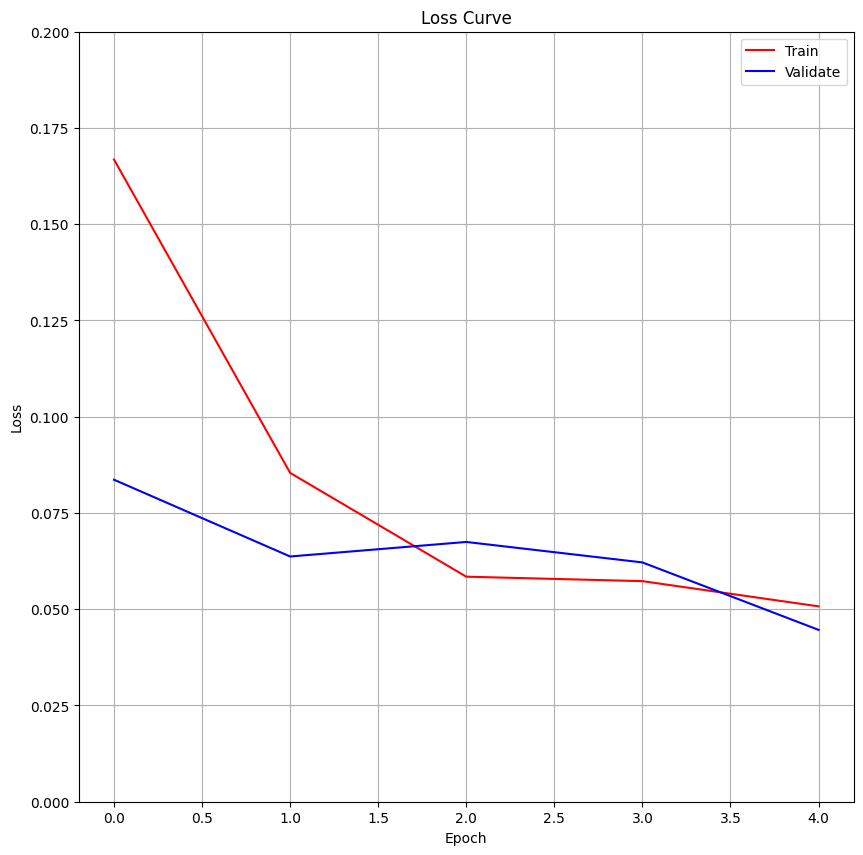

In [12]:
# Display loss curve

x_train = [n for n in range(len(train_losses))]
x_validate = [n for n in range(len(validate_losses))]
plt.rcParams["figure.figsize"] = (10,10)

plt.figure()
plt.grid()
plt.plot(x_train, train_losses,  color="red", label="Train")
plt.plot(x_validate, validate_losses,  color="blue", label="Validate")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.ylim(0, 0.2)

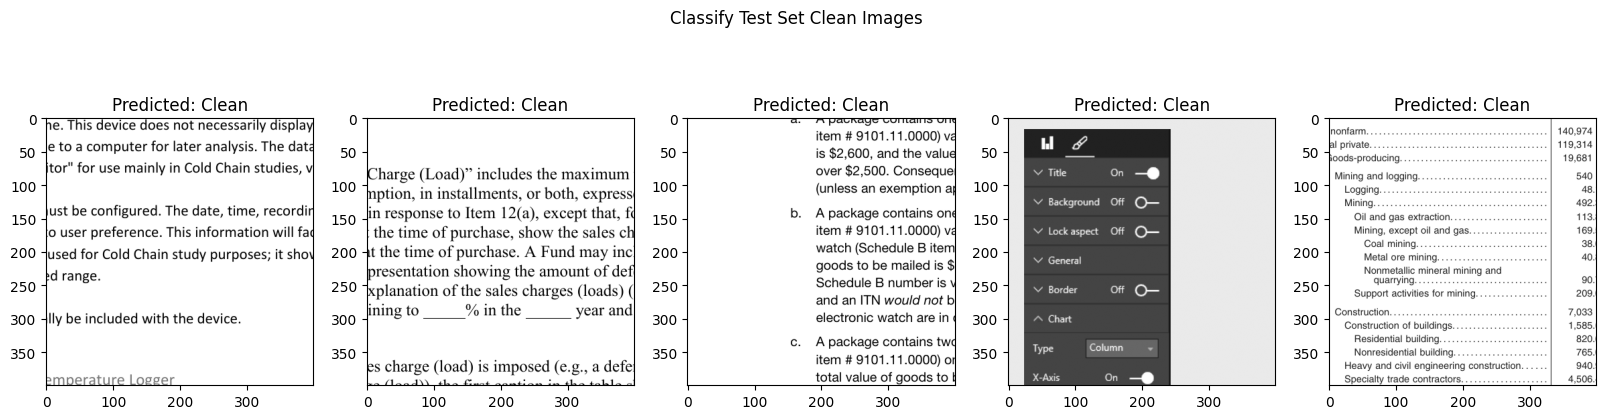

In [13]:
# Test with test set

plt.rcParams["figure.figsize"] = (20,5)

# Classify Clean images
model.eval()
with torch.no_grad():

    for batch_number, (noisy_samples, clean_samples) in enumerate(zip(validate_dirty_loader, validate_clean_loader)):

        noisy_data = noisy_samples[0].float().to(device)
        noisy_label = torch.tensor([1 for _ in range(len(noisy_samples[0]))]).float().to(device)
        clean_data = clean_samples[0].float().to(device)
        clean_label = torch.tensor([0 for _ in range(len(clean_samples[0]))]).float().to(device)

        # predict
        predicted_noisy_labels = model(noisy_data)
        predicted_clean_labels = model(clean_data)

        # Display predictions
        total_images = 5
        fig=plt.figure()
        fig.suptitle("Classify Test Set Clean Images")
        for i in range(total_images):

            plt.subplot(1,total_images,i+1)
            plt.imshow(clean_samples[0][i].reshape(image_size, image_size, 3))
            if predicted_clean_labels[i][0] > 0.5:
                 predicted_label = "Noisy"
            else:
                 predicted_label = "Clean"
            plt.title("Predicted: "+predicted_label)

        break

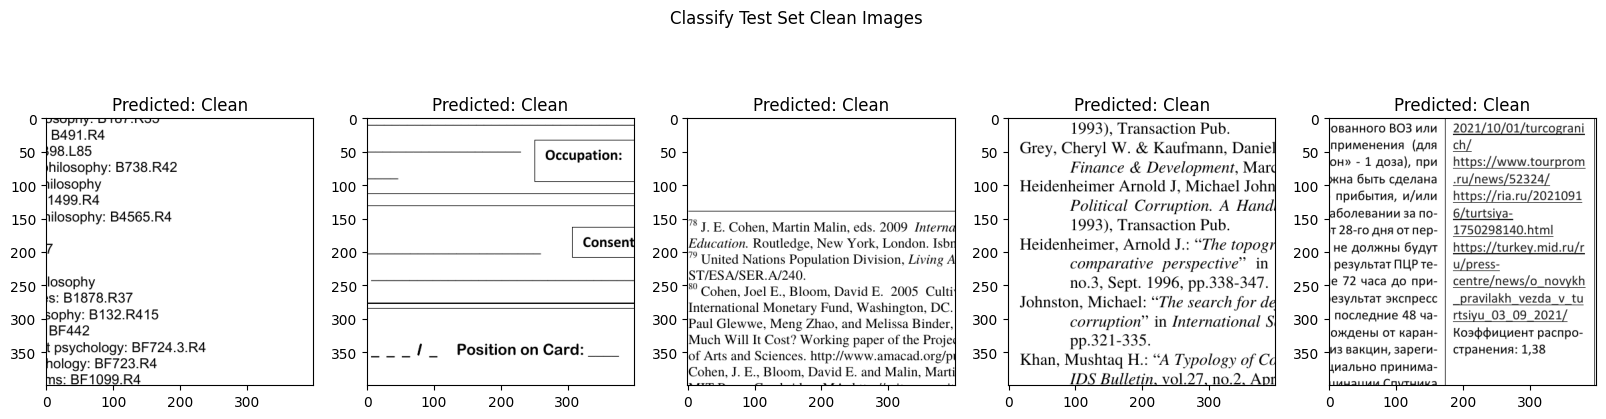

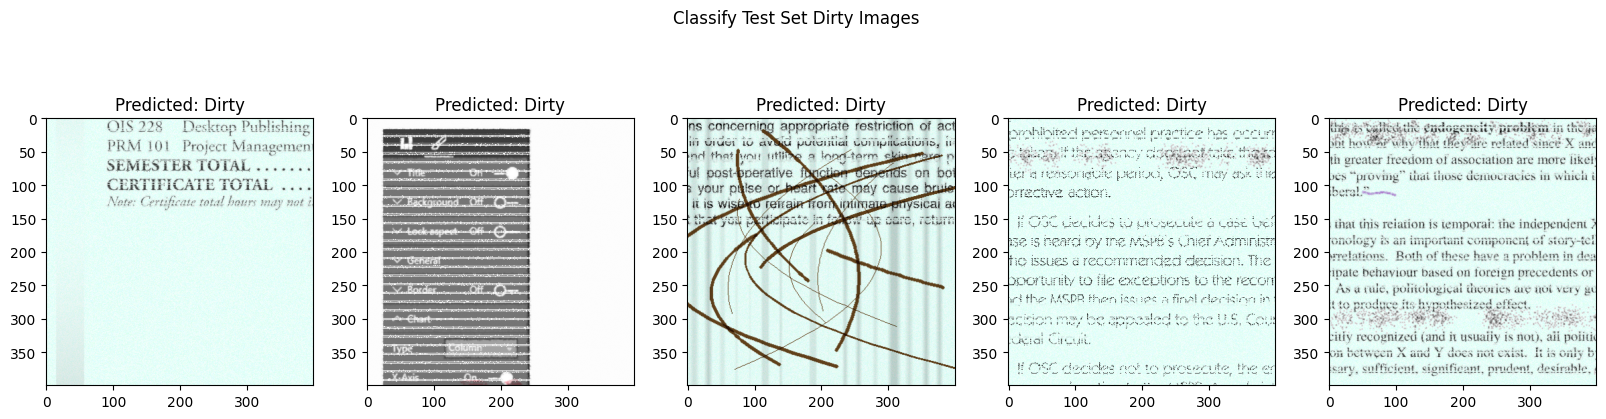

In [14]:
# Test with test set

plt.rcParams["figure.figsize"] = (20,5)

# Classify Clean images
model.eval()
with torch.no_grad():

    for batch_number, (noisy_samples, clean_samples) in enumerate(zip(validate_dirty_loader, validate_clean_loader)):

        noisy_data = noisy_samples[0].float().to(device)
        noisy_label = torch.tensor([1 for _ in range(len(noisy_samples[0]))]).float().to(device)
        clean_data = clean_samples[0].float().to(device)
        clean_label = torch.tensor([0 for _ in range(len(clean_samples[0]))]).float().to(device)

        # predict
        predicted_noisy_labels = model(noisy_data)
        predicted_clean_labels = model(clean_data)

        # Display predictions
        total_images = 5
        fig=plt.figure()
        fig.suptitle("Classify Test Set Clean Images")
        for i in range(total_images):

            plt.subplot(1,total_images,i+1)
            plt.imshow(clean_samples[0][i].reshape(image_size, image_size, 3))
            if predicted_clean_labels[i][0] > 0.5:
                 predicted_label = "Noisy"
            else:
                 predicted_label = "Clean"
            plt.title("Predicted: "+predicted_label)

        break


# Classify Dirty images

plt.rcParams["figure.figsize"] = (20,5)

model.eval()
with torch.no_grad():

    for batch_number, (noisy_samples, clean_samples) in enumerate(zip(validate_dirty_loader, validate_clean_loader)):

        noisy_data = noisy_samples[0].float().to(device)
        noisy_label = torch.tensor([1 for _ in range(len(noisy_samples[0]))]).float().to(device)
        clean_data = clean_samples[0].float().to(device)
        clean_label = torch.tensor([0 for _ in range(len(clean_samples[0]))]).float().to(device)

        # predict
        predicted_noisy_labels = model(noisy_data)
        predicted_clean_labels = model(clean_data)

        # Display predictions
        total_images = 5
        fig=plt.figure()
        fig.suptitle("Classify Test Set Dirty Images")
        for i in range(total_images):
            plt.subplot(1,total_images,i+1)
            plt.imshow(noisy_samples[0][i].reshape(image_size, image_size, 3))
            if predicted_noisy_labels[i][0] > 0.5:
                 predicted_label = "Dirty"
            else:
                 predicted_label = "Clean"
            plt.title("Predicted: "+predicted_label)

        break